# LED Data: Oct 25, 2022
## Import the libraries

In [1]:
import sys,os
import time 
import h5py

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import scipy
import scipy.optimize as opt
# import scipy.signal as sig
from scipy.interpolate import interp1d
from scipy.signal import periodogram,get_window,coherence,welch,csd

import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import MB_equations as MBe
import MB_analysis as MBa
import TimestreamHelperFunctions as Thf

## Gather the files

In [2]:
datapath = '/data/USRP_Laser_Data'
series   = "20221025_102305"

sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

## Load the summary file

In [3]:
md, charFs, charZs = Thf.UnpackSummary(sum_file, verbose=False)
rf_power = md['power']
print(charFs)
print(charZs)
print(rf_power)

[4242.049907 4242.05072  4242.051532]
[0.02500843+0.01204773j 0.02431747+0.01342315j 0.02406727+0.01526566j]
-30


/home/nexus-admin/NEXUS_RF/AnalysisScripts/TimestreamHelperFunctions.py:107: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


### LED voltages
Determine how many LED timestream files there are and get an array of the LED voltages used for each.

In [4]:
voltages = np.array([])

for k in md.keys():
    if 'LaserScan_' in k:
        voltages = np.append(voltages, float(int(1000*md[k]['LEDvoltage'][0]))/1000.)

n_volts  = len(voltages)
n_runs   = len(led_files)
print(n_volts, n_runs, "<-- These should be the same")

66 66 <-- These should be the same


### Define some PSD parameters

In [5]:
## PSD hi and lo frequency limits
chunk_up_to      = 1e2
decimate_down_to = 5e4

## Transient period at front of timestream
blank_fraction = 0.3

### Extract the pulse profile
This assumes that each laser timestream is acquired with the same AWG settings.

In [6]:
LED_rate_Hz = 0 # 100.0
lapse_sec   = 0 # 10.0

## Extract the pulse settings, assuming they're all the same
for k in md.keys():
    if 'LaserScan_' in k:
        LED_rate_Hz = md[k]['LEDfreqHz'][0]
        lapse_sec   = md[k]['duration'][0]
        break
LED_rate_Hz = LED_rate_Hz   #*5
print("Pulse f:",LED_rate_Hz,"Hz")
print("Duration:",lapse_sec,"sec")

total_pulses = LED_rate_Hz*lapse_sec

time_btw_pulse = 1./LED_rate_Hz
num_pulses = int(total_pulses * (1 - blank_fraction))
print("Total pulse windows:",total_pulses)
print("Time between pulse arrival:",time_btw_pulse,"sec")
print("Number of windows to look at:",num_pulses)

Pulse f: 100.0 Hz
Duration: 10.0 sec
Total pulse windows: 1000.0
Time between pulse arrival: 0.01 sec
Number of windows to look at: 700


## Noise cleaning to get cleaning coefficients

Will separate data into  1000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20221025/20221025_102305/USRP_Noise_20221025_102305_delta0.h5 because override=True!
found 45 pulses
chunk length plugged into welch is 500
chunked data into 1000 timestreams
computed electronics basis
cleaning...
(2, 331500)
(1, 331500)
(1, 331500)
(2, 331500)
(1, 331500)
(1, 331500)
saving clean_data to /data/USRP_Laser_Data/20221025/20221025_102305/USRP_Noise_20221025_102305_delta0_cleaned.h5 because override=True!
number of chunks used to average is 663
Converting to resonator basis!
Fr from fit  [GHz]: 4242.0507195560585
Fr min curve [GHz]: 4242.05042196569
Fr from

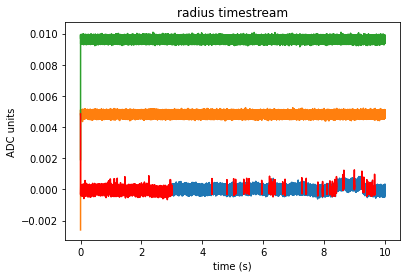

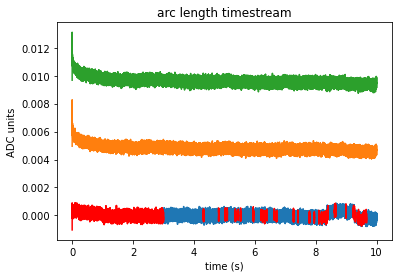

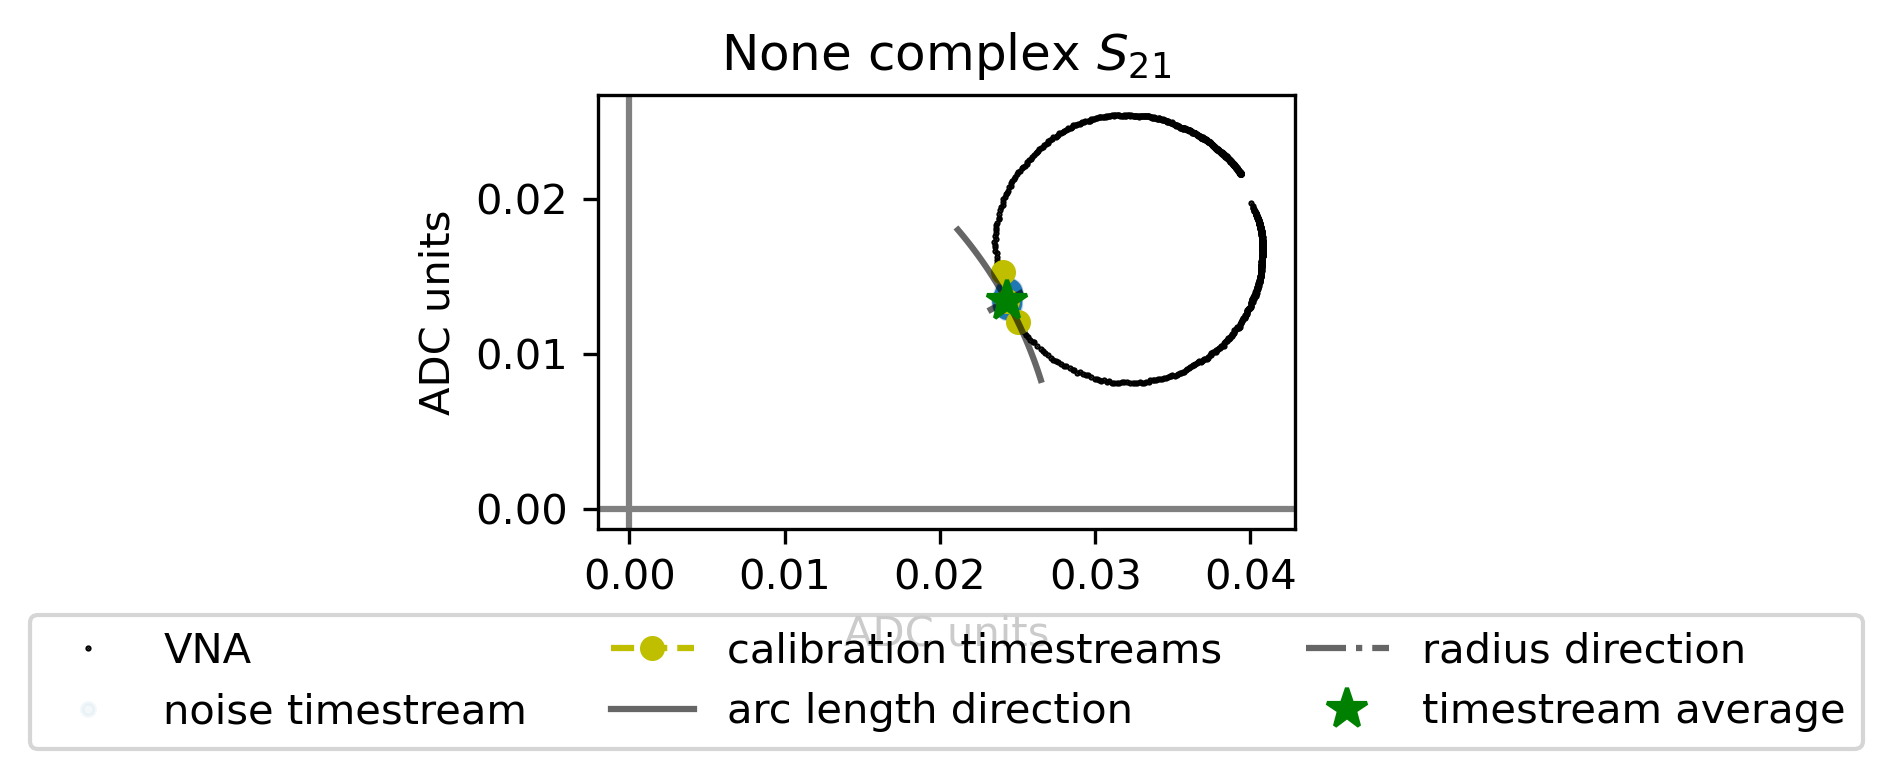

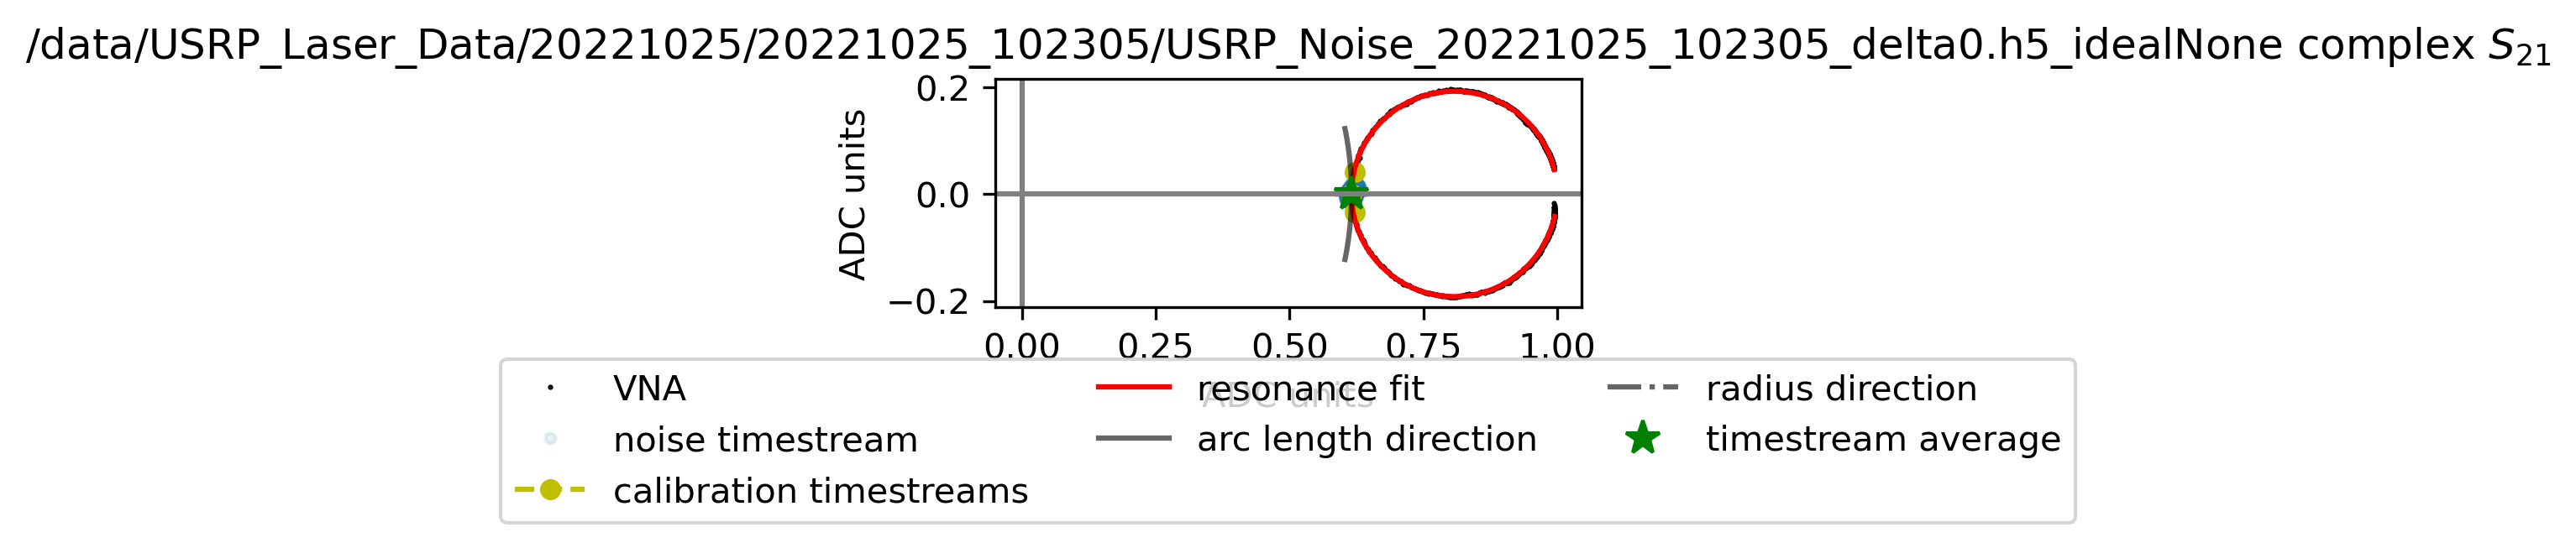

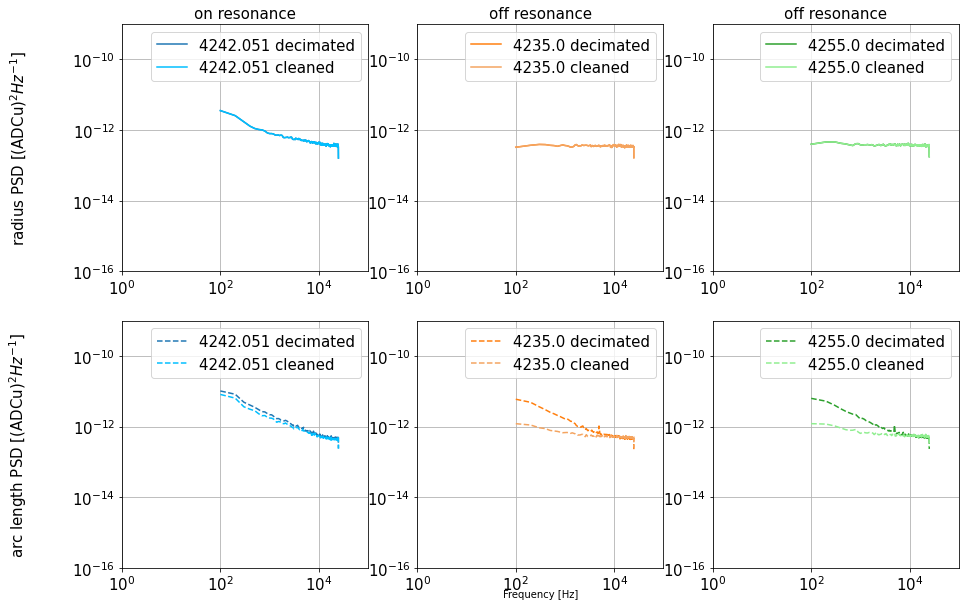

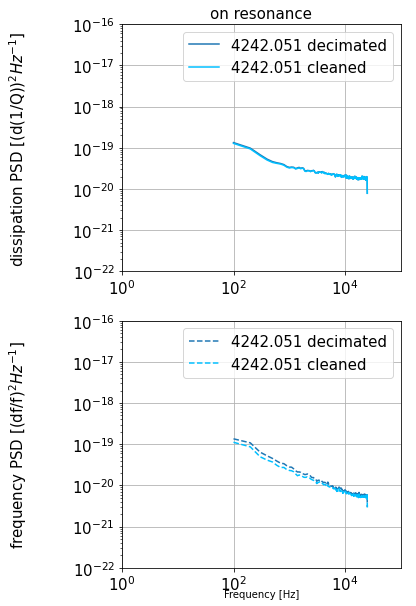

In [7]:
## Do the cleaning of the noise file
powers, PSDs, res, timestreams = Thf.CleanPSDs(
    nse_files[0], 
    vna_file, 
    PSD_lo_f=chunk_up_to, 
    PSD_hi_f=decimate_down_to, 
    f_transient=blank_fraction, 
    charFs=charFs, 
    charZs=charZs)

## Pulse cleaning

cleaning pulse file: /data/USRP_Laser_Data/20221025/20221025_102305/USRP_LaserOn_2.600V_20221025_102305.h5
using VNA file:      /data/USRP_Laser_Data/20221025/20221025_102305/USRP_VNA_20221025_102305.h5
using noise file:    /data/USRP_Laser_Data/20221025/20221025_102305/USRP_Noise_20221025_102305_delta0.h5
loaded pulse data
decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
Sampling rate: 50000.0 per sec
Samples per pulse window: 500
N=: 250 ; T= 0.005 ; (250,)
Starting pulse partitioning after 300 windows (of 1000.0 )
Shifting pulse window by 50 samples


ValueError: operands could not be broadcast together with shapes (250,3) (200,3) (250,3) 

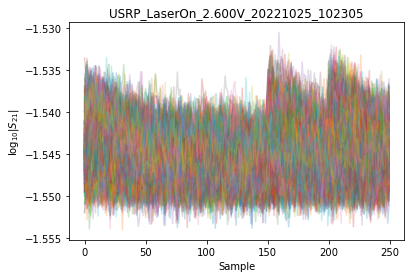

In [10]:
files_to_skip = 20
window_shift_seconds = 0.001 # -10e-6
verbose = True 
j = 0

for pulse_file in led_files[files_to_skip:]:
    print('===================')
    print('cleaning pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using noise file:   ',nse_files[0])
    noise_file = nse_files[0]

    ## Determine how much additional decimation to apply
    pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
    pulse_fs = 1./pulse_info['sampling period']
    pulse_cleaning_decimation = int(pulse_fs/decimate_down_to)

    if verbose:
        print('loaded pulse data')

    ## Get the decimated timestream and frequency step
    pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
    pulse_fs /= pulse_cleaning_decimation

    print('decimated data by ' + str(pulse_cleaning_decimation) + ' to achieve requested upper bound of ' + '{:2e}'.format(decimate_down_to) + ' Hz' )

    ## Create a new array of of frequency space with the applied decimation
    sampling_rate = pulse_fs
    samples_per_pulse = int(time_btw_pulse*sampling_rate)
    N = int(samples_per_pulse / 2) ## We look at the second half of a pulse window only
    T = N/sampling_rate
    _,f = Prf.build_t_and_f(N,sampling_rate)
    
    if verbose:
        print("Sampling rate:",sampling_rate,"per sec")
        print("Samples per pulse window:",samples_per_pulse)
        print("N=:",N,"; T=",T,";",np.shape(f))
    
    ## Define the regions where pulses exist
    ## =====================================
    
    ## This defines where (in # of pulse windows) to start looking for pulses
    pulse_start = int(total_pulses * blank_fraction)
    if verbose:
        print("Starting pulse partitioning after", pulse_start, "windows (of",total_pulses,")")
    
    ## How many samples to shift the pulse window definition
    window_shift = int(window_shift_seconds * sampling_rate)
    if verbose:
        print("Shifting pulse window by", window_shift, "samples")
    
    ## Create empty arrays to store our results in
    noise_averages = np.zeros((3),dtype=np.complex128)
    J_r = np.zeros((N,3)); J_arc = np.zeros((N,3))
    
    ## Create a plot to store waveforms
    if verbose:
        fig = plt.figure(pulse_file)
        ax0 = fig.gca()
        ax0.set_xlabel("Sample")
        ax0.set_ylabel(r"$\log_{10}|S_{21}|$")
        ax0.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse)
        
        ## Define the start of the pulse free region (period after pulse, before the next one, where it should be baseline noise)
        no_pulse_idx_start = pulse_i_end - N + window_shift
        
        ## Define the end of the window (where the pulse-free region ends)
        no_pulse_idx_end = pulse_i_end + window_shift
        
        ## Grab the timestream in that region and average it
        no_pulse_chunk = pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:]
        noise_averages += np.mean(pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:],axis=0,dtype=np.complex128) / num_pulses    
        
        ## Plot the pulse free region against time
        if verbose: # and (k==0):
            ax0.plot(np.log10(abs(no_pulse_chunk[:,0])),alpha=0.25)

        ## Convert to the electronics basis and compute the J objects
        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        J_r += abs(Prf.discrete_FT(r_chunk))**2 / num_pulses * 2 * T
        J_arc += abs(Prf.discrete_FT(arc_chunk))**2 / num_pulses * 2 * T
        
        k+=1
    
    if verbose:
        print("Searched",k,"pulse windows")

    if verbose:
        ax0.axhline(y=np.log10(abs(noise_averages[0])),color="k",ls='--')
        print('used ' + str(k) + ' chunks to find quiescent point')
    
#     if j % 4 == 0:
#         fig, ax = plt.subplots(1,2,figsize=(5,10))
#         ax[0].plot(f[f>0],J_r[f>0],color='C'+str(j%10))
#         ax[1].plot(f[f>0],J_arc[f>0],color='C'+str(j%10))
#         ax[0].set_yscale('log'); ax[0].set_xscale('log'); ax[1].set_yscale('log'); ax[1].set_xscale('log')

    # print(noise_averages)
    radius_averages = abs(noise_averages)
    angle_averages = np.angle(noise_averages)
    if verbose:
        print(radius_averages)
        print(angle_averages)

    pulse_timestream_rotated = pulse_noise*np.exp(-1j*angle_averages)
    angle_timestream = np.angle(pulse_timestream_rotated)

    radius = abs(pulse_noise) - radius_averages
    arc = angle_timestream*radius_averages

    radius_clean = np.zeros(radius.shape)
    arc_clean = np.zeros(arc.shape)

    if verbose:
        print('built radius and arc length timestreams given by quiescent point')

        print(noise_file)
    _,data_info = PUf.clean_noi(noise_file[:-3]+'_cleaned.h5')

    for t in range(radius.shape[1]):
        radius_coefficient = data_info['radius cleaning coefficient'][t]
        arc_coefficient = data_info['arc cleaning coefficient'][t]

        if t == 0:
            off_tone_idcs = [1,2]
        elif t == 1:
            off_tone_idcs = [2]
        elif t == 2:
            off_tone_idcs = [1]


        off_tone_radius = np.mean(radius[:,off_tone_idcs],axis=1,dtype=np.float64)
        radius_clean[:,t]= radius[:,t] - radius_coefficient*off_tone_radius

        off_tone_arc = np.mean(arc[:,off_tone_idcs],axis=1,dtype=np.float64)
        arc_clean[:,t] = arc[:,t] - arc_coefficient*off_tone_arc

        if verbose: 
            print('cleaned tone ' + str(t))

#     print(np.mean(radius_clean))
    radius_clean -= np.mean(radius_clean,axis=0,dtype='float64')
    arc_clean -= np.mean(arc_clean,axis=0,dtype='float64')
#     print(np.mean(radius_clean))
#     print(radius_averages.shape, radius_clean.shape)
#     data_clean = (radius_averages+radius_clean)#*np.exp(1j*((arc_clean/radius_averages)+angle_averages))
    # data_clean = (np.mean(abs(data_raw),axis=0,dtype=np.float64)+cd1_clean)*np.exp(1j*((cd2_clean/np.mean(abs(data_raw),axis=0,dtype=np.float64))+np.angle(np.mean(data_raw,axis=0,dtype=complex))))
    # print(cd1_coeff)

#     data_clean_average = np.mean(data_clean,dtype='float64')
#     print(abs(data_clean_average))
#     print(np.angle(data_clean_average))

    pulse_noise_clean = Prf.save_clean_timestreams(pulse_file,\
                                                   radius_averages,\
                                                   angle_averages,\
                                                   radius_clean,\
                                                   arc_clean,\
                                                   sampling_rate,\
                                                   timestreams['radius coefficient'],\
                                                   timestreams['arc coefficient'],\
                                                   override=True)

    J_r_clean = np.zeros((N,3)); J_arc_clean = np.zeros((N,3))
    for pulse_i in range(pulse_start,int(total_pulses),1):                
        pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
        no_pulse_idx_start = pulse_i_end - N + window_shift
        no_pulse_idx_end = pulse_i_end + window_shift
        no_pulse_chunk = pulse_noise_clean[no_pulse_idx_start:no_pulse_idx_end,:]

        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        J_r_clean += abs(Prf.discrete_FT(r_chunk))**2 / num_pulses * 2 * T
        J_arc_clean += abs(Prf.discrete_FT(arc_chunk))**2 / num_pulses * 2 * T


    J_r = J_r[f>=0]; J_r_clean = J_r_clean[f>=0]; J_arc = J_arc[f>=0]; J_arc_clean = J_arc_clean[f>=0]
    if j % 10 == 0:
        fig_0, axes_0 = plt.subplots(2,3,sharex=True,sharey='row',figsize=(5*3,10))
        print(pulse_file)
        Prf.plot_PSDs(f[f>0],J_r,J_arc,pulse_file,\
                      ['radius','arc length'],units=['ADCu','ADCu'],savefig='electronics',\
                      data_freqs=pulse_info['search freqs'],\
                      P_1_clean=J_r_clean,P_2_clean=J_arc_clean,\
                      fig_0=fig_0,axes_0=axes_0)
        # ax[0].plot(f[f>0],J_r[f>0],color='C'+str(j%10),ls='--')
        # ax[1].plot(f[f>0],J_arc[f>0],color='C'+str(j%10),ls='--')
        # ax[0].set_yscale('log'); ax[0].set_xscale('log'); ax[1].set_yscale('log'); ax[1].set_xscale('log')
        # ax[0].set_ylim([10**-16,10**-9]); ax[1].set_ylim([10**-16,10**-9])


    j += 1

## Pulse averaging

In [ ]:
%matplotlib inline
NDF_pulse_avg = []
NDF_pulse_data_info = []
i = 0

fraction_to_keep = 0.5
window_shift_seconds = 5e-3 # 100e-6
verbose = True

j = 0 
for pulse_file in led_files:
    f,z = PUf.read_vna(vna_file)

    print('===================')
    print('averaging pulse file: ' + pulse_file)

    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    pulse_noise_clean,data_info = PUf.clean_noi(clean_pulse_file)
    if verbose: 
        print('loaded clean pulse data')        
        print('sampling_rate: ' + str(data_info['sampling_rate']))
    NDF_pulse_data_info.append(data_info)
    samples_per_pulse = data_info['sampling_rate'] * time_btw_pulse

    decimation = 1
    time = Prf.average_decimate(pulse_info['time'],decimation)
    pulse_noise_clean = Prf.average_decimate(pulse_noise_clean,decimation)
    samples_per_pulse_decimated = int(samples_per_pulse / decimation)
    sampling_rate = data_info['sampling_rate'] / decimation
    if verbose:
        print('further decimation by ' + str(decimation) + ' complete')

    # idcs_keep = np.zeros(int(num_pulses*samples_per_pulse_decimated*fraction_to_keep),dtype=int)
    pulse_avg = np.zeros(int(samples_per_pulse_decimated*fraction_to_keep),dtype=np.complex128)
    window_shift = int(window_shift_seconds*sampling_rate)
#     print(pulse_avg)
    pulse_start = int(total_pulses * blank_fraction)
    # print(idcs_keep.shape)
    k = 0
    for pulse_i in range(pulse_start,int(total_pulses),1):
    #     print(pulse_i)
        pulse_idx_start = int(pulse_i*samples_per_pulse_decimated) + window_shift
        pulse_idx_end = int(round((pulse_i+fraction_to_keep)*samples_per_pulse_decimated,0)) + window_shift
    #     print(pulse_idx_start,pulse_idx_end)
        # print(np.arange(pulse_idx_start*2+samples_per_pulse,pulse_idx_end*2,1))
    #     print(pulse_idx_start*2+samples_per_pulse,pulse_idx_end*2)
        pulse_idx_list = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
    #     print(pulse_idx_list[0],pulse_idx_list[-1])
        pulse_avg += pulse_noise_clean[pulse_idx_list,0] / num_pulses
        k += 1
    if j == j:
        color = 'C' + str(j % 10)
        plt.figure()
        plt.plot(pulse_noise_clean[:,0].real,pulse_noise_clean[:,0].imag,ls='',marker='.',alpha=0.1,color='grey')
        plt.plot(pulse_avg.real,pulse_avg.imag,color=color,ls='-',marker='.')
        plt.plot(z.real,z.imag,color='k',ls='-',marker='.',alpha=0.01)
        width = 50 * np.std(pulse_noise_clean[:,0].real)
        x_c = np.mean(pulse_avg.real)
        y_c = np.mean(pulse_avg.imag)
        plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
        ax = plt.gca(); ax.set_aspect('equal','box')
        plt.title(pulse_file.split("/")[-1])
        # plt.savefig('noise and averaged pulse.png',dpi=100)
#     print(pulse_avg)
    print('Used ' + str(k) + ' pulses to average')
        # print('===================')
    NDF_pulse_avg.append(pulse_avg)
    with h5py.File(clean_pulse_file, "a") as fyle:
        if 'pulse_shape' in fyle.keys():
            del fyle['pulse_shape']
            print('deleted an old pulse shape')
        fyle.create_dataset('pulse_shape',data = np.asarray(pulse_avg))
    j += 1

## Pulse rotation

In [ ]:
j = 0

last_width = 0.
time_window_range = fraction_to_keep * time_btw_pulse *1e6
time_window = np.arange(window_shift_seconds*1e6,time_window_range+window_shift_seconds*1e6,1/sampling_rate*1e6)
for pulse_file in led_files:
    print('===================')
    print('cleaning pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using summary file: ',sum_file)
    char_file = sum_file

    AWF_string = "10 us"
    title_1 = 'power ' + str(rf_power) + '; AWF ' + AWF_string[4:] + ': pulses in S21'
    title_1p5 = 'power ' + str(rf_power) + '; AWF ' + AWF_string[4] + ': pulses in S21, zoomed in'
    title_1p75 = 'alignment of pulses using largest pulse (blue)'
    # title_2 = 'power ' + power_directories[j][:-1] + ': timestream along rotated axis'    
    title_2 = 'S_21 pulse height along pulse alignment axis'
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    with h5py.File(clean_pulse_file, "r") as fyle:
        pulse_avg = np.array(fyle["pulse_shape"],dtype=np.complex128)
        pulse_timestream = np.array(fyle["cleaned_data"],dtype=np.complex128)
#     with h5py.File(char_file,'r') as fyle:
#         char_points = np.array(fyle['means'])
#         char_f = np.array(fyle['frequencies'])
#         readout_f = char_f[0]
    readout_f = charFs[1]
    f,z = PUf.read_vna(vna_file)

    # print(pulse_fs)
    df_f, d1_Q, _, _ = Prf.resonator_basis(pulse_avg,readout_f*1e-3,f*1e-3,z,charFs*1e-3,charZs)#,plot_title='power ' + power_directories[j][:-1] + ' AWF ' + AWF_string)
    df_f_timestream, d1_Q_timestream, _, _ = Prf.resonator_basis(pulse_timestream[:,0],readout_f*1e-3,f*1e-3,z,charFs*1e-3,charZs)
    # plt.axis([0.058, 0.062, -0.19, -0.15])

    pulse_avg_mb = pulse_avg - np.mean(pulse_avg[-5:],dtype=np.complex128)
    if i == 0:
        std = np.std(abs(pulse_avg_mb[-5:]),dtype=np.complex128)
        # average_angle = np.mean(np.angle(pulse_avg_mb[abs(pulse_avg_mb) > 5*std]))
        # average_angle = np.mean(np.angle(pulse_avg_mb[abs(pulse_avg_mb[time_window > 200]) > 5*std]))
        average_angle = np.mean(np.angle(pulse_avg_mb[np.logical_and(time_window>200,time_window<300)]))
    pulse_timestream_mb = pulse_timestream[:,0] - np.mean(pulse_avg[-5:],dtype=np.complex128)

    pulse_avg_rotated = pulse_avg_mb * np.exp(-1j*average_angle)
    pulse_timestream_rotated = pulse_timestream_mb * np.exp(-1j*average_angle)

    # template = df_f
    # noise = df_f_timestream

    template = pulse_avg_rotated.real #pulse_avg_rotated.real
    noise = pulse_timestream_rotated.real
    # print(len(pulse_avg),len(df_f))

    with h5py.File(clean_pulse_file, "a") as fyle:
        if 'df_f_template' in fyle.keys():
            del fyle['df_f_template']
        if 'df_f_pulse_noise' in fyle.keys():
            del fyle['df_f_pulse_noise']
        fyle.create_dataset('df_f_template',data = np.asarray(template))
        fyle.create_dataset('df_f_pulse_noise',data = np.asarray(noise))
    if i % 1 == 0:
        label_c = 'characterization data' if i == 0 else None
        label_V = 'VNA' if i == 0 else None
        label_p = 'pulse data; 0V-18V @ LED breadboard ' if i == 0 else None
        plt.figure(title_1)
        plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
        plt.plot(z.real,z.imag,color='k',label=label_V)
        plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
        plt.axhline(0,color='grey')
        plt.axvline(0,color='grey')
        plt.title(title_1)
        width = 8e3 * np.std(pulse_avg.real)
        x_c = np.mean(pulse_avg.real)
        y_c = np.mean(pulse_avg.imag)
        plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
        ax = plt.gca()
        ax.set_aspect('equal','box')
        plt.legend()

        plt.figure(title_1p5)
        plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10),label=label_p,zorder=-5*i+200)
        plt.plot(z.real,z.imag,color='k',label=label_V)
        plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
        plt.title(title_1p5)

        if i == 0:
            width = 150 * np.std(pulse_avg.real)
            x_c = np.mean(pulse_avg.real)
            y_c = np.mean(pulse_avg.imag)
            plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
            plt.legend()
        # plt.axis([0.055,0.06,-0.175,-0.17])
        # plt.axis([-0.025,-0.023,-0.031,-0.029])
        # plt.savefig('power_' + power_directories[j][:-1] + '_AWF_' + NDF_directories[i][:-1] + '_S21_100mK.png')

        if i % 3 == 0:
            plt.figure(title_1p75)
            plt.plot(pulse_avg_rotated.real,pulse_avg_rotated.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
            ax = plt.gca()
            ax.set_aspect('equal', 'box')
            plt.title(title_1p75)



    AWF_idx = AWF_string.find('us')
    width = float(AWF_string[AWF_idx-3:AWF_idx])
    plt.figure(title_2)
    radius, arc_length, _, _ = Prf.electronics_basis(pulse_avg)
    # pulse_avg_plot = arc_length
    # pulse_avg_plot = pulse_avg.imag - np.mean(pulse_avg[:20].imag)
    pulse_avg_plot = template

    plt.plot(time_window,pulse_avg_plot,ls='-',marker='.',markersize=5,color='C'+str(i))
    # print((100+last_width,-4e-7),current_width-last_width)
    if i == 0:
        plot_max = max(pulse_avg_plot)
        ax = plt.gca()
        ax.add_patch(mpatches.Rectangle((0,0),width,plot_max*1.1,alpha=0.4,color='C'+str(i)))
    plt.xlim([window_shift_seconds-10, 1000])
    plt.xlabel('microseconds')
    plt.title(title_2)
    # plt.ylim([-4e-7,4e-7])

    if i == 0:
        stored_pulse = pulse_avg_rotated.real
    elif i == 8:
        current_pulse = pulse_avg_rotated.real
        ratio = stored_pulse / current_pulse
        plt.figure('ratio of pulses')
        plt.plot(time_window,ratio)
        plt.xlim([-10, 1000])
        plt.ylim([-1,10])


    # plt.savefig('power_' + power_directories[j][:-1] + '_d1_Q_100mK.png')
    i += 1
j += 1
    
directory = "/data/ProcessedOutputs/out"+series
plt.figure(title_1)
# plt.savefig(directory + 'VNA_char_pulse_S21.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_1p5)
# plt.savefig(directory + 'VNA_char_pulse_S21_zoomed_in.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_1p75)
# plt.savefig(directory + 'pulse_alignment.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_2)
# plt.savefig(directory +'timestream_aligned',dpi=300,facecolor='white',transparent=False)

## Optimal Filter code

In [ ]:
%matplotlib inline
from statistics import mode
import scipy
import numpy.fft as fft
reload(Prf)
i = 0
verbose = False
for NDF_pulse_files,NDF_pulse_vna_file in zip(power_NDF_pulse_files,power_NDF_pulse_vna_files):
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`')
#     print(power_directories,i)
    print('power: ' + power_directories[i][:-1])
    
    title_1 = 'readout power ' + power_directories[i][:-1] + ': signal template'
    title_1p5 = 'readout power ' + power_directories[i][:-1] + ': signal in time'
    title_2 = 'readout power ' + power_directories[i][:-1] + ': noise power spectral density'
    title_2 = 'noise power spectral densities'
    title_2p1 = 'examples of V in time'
    title_2p25  = 'convolution'
    title_2p5 = 'index of IFFT with peak value'
    title_3 = 'readout power ' + power_directories[i][:-1] + ': histogram of pulse heights'
    title_4 = 'readout power ' + power_directories[i][:-1] + ': sigma vs mu'
    
    clean_pulse_file = NDF_pulse_files[0][:-3] + '_cleaned.h5'
    with h5py.File(clean_pulse_file, "r") as fyle:
        N = len(np.array(fyle["df_f_template"]))
        sampling_rate = np.array(fyle['sampling_rate'])
    
    T = N/sampling_rate
    time, f = Prf.build_t_and_f(N,sampling_rate)
            
    f_max = 1e4
    f_mask = np.logical_and(f <= f_max, f >= -1*f_max)
    N_mask = len(f[f_mask])
    f_plot = np.logical_and(f > 0, f <= f_max)
    new_fs = max(f[f_mask])
    
    offset_exponent = np.zeros((N_mask,N_mask),dtype=np.complex128)
    time_ds = np.linspace(0,(N_mask-2)/(2*new_fs),N_mask)
    print((N_mask-1)/(2*new_fs))
    for j in range(N_mask):
        offset_exponent[j,:] = np.exp(1j*2*np.pi*f[f_mask][j]*time_ds)
        
    for j in range(N_mask):
        for k in range(N_mask):
            if abs(offset_exponent[j,k].real) < 1e-10:
                offset_exponent[j,k] = 1j*offset_exponent[j,k].imag
            if abs(offset_exponent[j,k].imag) < 1e-10:
                offset_exponent[j,k] = offset_exponent[j,k].real
    
    mu = np.zeros((len(NDF_pulse_files),N_mask))
    sigma = np.zeros((len(NDF_pulse_files),N_mask))
    j = 0
    s_found = False
    for pulse_file in NDF_pulse_files:
        if verbose: 
            print('=====================')
            print('analyzing data file: ' + pulse_file)
        color = 'C'+str(j%10)
#         print(pulse_file)
        clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
        with h5py.File(clean_pulse_file, "r") as fyle:
            pulse_avg = np.array(fyle["df_f_template"])            
            pulse_noise = np.array(fyle["df_f_pulse_noise"])

    #     pulse_avg = np.polyval(dtheta_to_energy_fit,pulse_avg)
    #     pulse_noise = np.polyval(dtheta_to_energy_fit,pulse_noise)
        t_offset = lambda N: 0 #N//2
        # t_offset = lambda N: 0
        pulse_recentered = np.concatenate((pulse_avg[t_offset(N):],pulse_avg[:t_offset(N)]))
        # pulse_recentered = np.concatenate(np.zeros())
        w = scipy.signal.blackman(N_mask)
        exponential = lambda x, A, tau: np.heaviside(x-time[t_offset(N)],1) * A * np.exp(-1*(x-time[t_offset(N)])/tau)
        # exponential = lambda x, A, tau_qp: A * np.exp(-1*x/tau)
        popt,_ = opt.curve_fit(exponential,time,pulse_recentered,[1.2e-4,50e-6])
        pulse_fit = exponential(time,*popt)
        s_temp = Prf.discrete_FT(pulse_recentered)
        if j == 0:
            A = np.trapz(pulse_fit,dx = time[1]-time[0])
            # s = Prf.discrete_FT(pulse_fit/A)
            # s = fft.ifft(pulse_recentered) / max(pulse_recentered)
            s = Prf.discrete_FT(pulse_fit)#/max(pulse_recentered))
        # if j <= len(NDF_pulse_files)-5:
            plt.figure(title_1)
            S_mag = abs(s[f_mask]**2)
            plt.plot(f[f_plot],abs(s[f_plot]**2),zorder=-5*j+5,color='k',linewidth=3)
            plt.figure(title_1p5)
            plt.plot(time,pulse_fit,'k',linewidth=3,label='time constant: {:.2e}us'.format(popt[1]*1e6) )
            plt.plot(time,pulse_recentered)
            plt.legend()
        plt.figure(title_1)
        plt.plot(f[f_plot],abs(s_temp[f_plot]**2),zorder=-5*j+5,color=color)

    #     pulse_filter = pulse_avg[::-1]/max(pulse_avg)
    #     plt.figure(10)
    #     plt.plot(pulse_filter,zorder=100-5*i)
    #     filtered_data = scipy.signal.fftconvolve(pulse_noise, pulse_filter, mode="valid")

    #     time = np.linspace(0,len(filtered_data)/sampling_rate,len(filtered_data))
    #     print(time,filtered_data)
    #     plt.figure(1)
    #     plt.plot(time,filtered_data)
    #     plt.xlim([4.005,4.010])
        
        samples_per_pulse = sampling_rate*time_btw_pulse
        window_shift_J = -10e-6
        window_shift_J_idx = int(window_shift_J*sampling_rate)
        J_temp = np.zeros(N)
        # for pulse_i in range(num_pulses):
        for pulse_i in range(pulse_start,int(total_pulses),1):                
            pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
            no_pulse_idx_start = pulse_i_end - N + window_shift_J_idx
            no_pulse_idx_end = pulse_i_end + window_shift_J_idx
            no_pulse_idx_list = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
            no_pulse_noise_i = pulse_noise[no_pulse_idx_list]
            # if pulse_i == 0:
            #     print(time[no_pulse_idx_start])

            J_temp += abs(Prf.discrete_FT(no_pulse_noise_i))**2 / num_pulses * 2 * T
            # J_temp += abs(fft.ifft(no_pulse_noise_i))**2 / num_pulses * 2 * T
            
        if j == 0:
            J = J_temp
            plt.figure(title_2)
            plt.plot(f[f_plot],J[f_plot],zorder=-5*j+5,color='k',linewidth=3)
        else:
            plt.figure(title_2)
            plt.plot(f[f_plot],J_temp[f_plot],zorder=-5*j+5,color=color)
            
            
        plt.figure(title_2)
        plt.plot(f[f_plot],J[f_plot],zorder=-5*j+5,color=color)
        denominator = np.sum(abs(s[f_mask])**2/J[f_mask])


        A_hat = np.zeros((num_pulses,N_mask))
        A_max_idx = np.zeros(num_pulses)
        A_hat_max = np.zeros(num_pulses)
        A_hat_sum = np.zeros(num_pulses)
        # numerator_sum = np.zeros(N_mask)

        b7_res = np.sqrt(((2*T*denominator)**-1))
        k = 0
        t_offset_idx = t_offset(N_mask)
        for pulse_i in range(pulse_start,int(total_pulses),1):
            pulse_i_start = int(pulse_i*samples_per_pulse)
            pulse_idx_start = pulse_i_start + window_shift
            pulse_idx_end = pulse_idx_start + N
            pulse_idx_list = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
            pulse_noise_i = pulse_noise[pulse_idx_list]
            # pulse_noise_i_recentered = np.concatenate((pulse_noise_i[N//2:],pulse_noise_i[:N//2]))

            v = Prf.discrete_FT(pulse_noise_i - np.mean(pulse_noise_i[-5:])) 
            # v_ps = abs(v)**2 
            # v_ps = v[f_plot]
            # v = fft.fft(pulse_noise_i - np.mean(pulse_noise_i[-5:])) / N_mask

            
            pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
            no_pulse_idx_start = pulse_i_end - N + window_shift_J_idx
            no_pulse_idx_end = pulse_i_end + window_shift_J_idx
            no_pulse_idx_list = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
            no_pulse_noise_i = pulse_noise[no_pulse_idx_list]
            v_temp = Prf.discrete_FT(no_pulse_noise_i)

                        
            if j == 0 and (pulse_i + 2) % 200 == 0:
                plt.figure(title_2p1)
                # plt.plot(time,no_pulse_noise_i,color='grey')
                plt.plot(time,pulse_noise_i,color='k')
                
            numerator = Prf.discrete_IFT(np.conj(s[f_mask])*v[f_mask]/J[f_mask])
            numerator = numerator.real
            
            numerator_sum = sum(offset_exponent[:,t_offset_idx]*np.conj(s[f_mask])*v_temp[f_mask]/J[f_mask])
            numerator_sum = numerator_sum.real
            # if pulse_i % 100 == 0: 
            #     print(numerator_sum)
#             if pulse_i % 50 == 0:
#                 idx_range = 20
#                 plt.plot(np.arange(-idx_range,0,1),numerator[-idx_range:]/denominator,ls='',marker='.',color=color)
#                 plt.plot(np.arange(0,idx_range,1),numerator[:idx_range]/denominator,ls='',marker='.',color=color)
            
            max_numerator = max(numerator)
            max_idx = np.argwhere(numerator == max_numerator)
        
            A_max_idx[k] = max_idx 
            A_hat[k,:] = numerator / denominator
            
            A_hat_max[k] = max_numerator/denominator
            
            A_hat_sum[k] = numerator_sum / denominator
            k += 1
        
    
        for k in range(N_mask):
            (mu[j,k], sigma[j,k]) = scipy.stats.norm.fit(A_hat[:,k])
        # optimal_t0 = t_offset(N_mask)
        if j == 0:
            # optimal_t0 = int(mode(A_max_idx))
            optimal_t0 = t_offset_idx
        (mu_max, sigma_max) = scipy.stats.norm.fit(A_hat_max)
        (mu_sum, sigma_sum) = scipy.stats.norm.fit(A_hat_sum)
        print('mu = ' + "{:.2e}".format(mu[j,t_offset_idx]) + '; sigma = ' + "{:.2e}".format(sigma[j,t_offset_idx])+ '; sigma_0 = ' + "{:.3e}".format(b7_res))
#         try:            
        if not 'no NDF' in pulse_file:
            plt.figure(title_2p5)
            n, bins, patches = plt.hist(A_max_idx,bins=N,fill=False,histtype='step',label='radians',color=color)
            if j % 1 == 0:
                plt.figure(title_3)
                if j == 0:
                    n, bins, patches = plt.hist(A_hat[:,optimal_t0],bins=25,fill=False,histtype='step',label='radians',color=color)
                    bin_width = bins[1]-bins[0]
                else:
                    data = A_hat[:,optimal_t0]
                    n, bins, patches = plt.hist(data,bins=np.arange(min(data), max(data) + bin_width, bin_width),fill=False,histtype='step',label='radians',color=color)
                plt.plot(np.linspace(bins[0],bins[-1],100),\
                         len(A_hat)*(bins[1]-bins[0])*scipy.stats.norm.pdf(np.linspace(bins[0],bins[-1],100),mu[j,optimal_t0],sigma[j,optimal_t0]),\
                         c='gray')

            # mu2s.append(mu2); sigma2s.append(sigma2)
            # mus.append(np.mean(mu)); sigmas.append(np.mean(sigma))

            plt.figure(title_4)
            if j == 0:
                label1 = 'triggering on signal'
                label2 = 'triggering on noise'
            else:
                label1 = None
                label2 = None
            plt.plot(mu[j,optimal_t0],sigma[j,optimal_t0],color=color,ls='',marker='s',label=label1)
            plt.plot(mu_sum,sigma_sum,ls='',marker='s',color='k',markersize=2,label=label2)
            # plt.plot(mu2,sigma2,color=color,ls='',marker='x')
            # plt.plot(mu_sum,sigma_sum,color='k',ls='',marker='s',markersize=2)


#         except:
#             pass
        j += 1
        
    plt.figure(title_1)
    ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
    plt.title(title_1)
    
    plt.figure(title_1p5)
    plt.title(title_1p5)
    
    plt.figure(title_2)
    ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
    J_avg = np.mean(J)
    plt.ylim([1e-1*J_avg,1e2*J_avg])
    plt.title(title_2)
    
    plt.figure(title_2p1)
    plt.title(title_2p1)
    
    plt.figure(title_2p5)
    plt.title(title_2p5)
    plt.xlabel(r'index of IFFT($\frac{s^*v}{J}$)')
    
    plt.figure(title_3)
    plt.title(title_3)
    plt.xlabel('pulse heights normalized to tallest pulse')
    plt.ylabel('# of pulses')
#     plt.xlim([-0.25,0.5])
    # ax = plt.gca(); ax.set_yscale('log');
    # plt.ylim([10**-1,10**3])

    plt.figure(title_4)
#     plt.title(title_4)
    plt.axhline(b7_res,color='grey',label='baseline resolution')
    plt.xlabel('pulse height normalized to tallest pulse',fontsize=18)
    plt.ylabel('$\sigma$',fontsize=18)
    plt.legend()
    plt.ylim([0.2,0.5])
    
    plt.figure()
    print(sigma.shape)
    for j in range(N_mask):
        plt.plot(np.mean(sigma,axis=0))
        plt.plot(optimal_t0,np.mean(sigma[:,optimal_t0]),ls='',marker='.',color='k')
    # print(np.mean(np.mean(sigma[-8:])))
    plt.xlabel('time offset')
    plt.ylabel('OF noise')
    plt.title('triggering on noise before pulse')
    # plt.savefig('triggering_on_noise_after_pulse',dpi=300,facecolor='white',transparent=False)
    
    def sig(mu,sigma_0,r):
        return np.sqrt(sigma_0**2 + (mu)*r)

    import scipy
    p0 = [1e-1,1e-2]
    # f_fit_vals,_ = scipy.optimize.curve_fit(f,mu[:,],sigmas[1:],p0,bounds=[(15*(0.008/2.6),7e-3),(40*(0.008/2.6),0.1)])
#     f_fit_vals,_ = scipy.optimize.curve_fit(f,mus[1:],sigmas[1:],p0)
#     f_fit_vals1,_ = scipy.optimize.curve_fit(f,mu1s[1:],sigma1s[1:],p0)
#     f_fit_vals2,_ = scipy.optimize.curve_fit(f,mu2s[1:],sigma2s[1:],p0)
#     #     for i in range(len(mus)):
#     #         print(f_fit_vals[0],mus[i]*f_fit_vals[1])

#     sigma_0_E_pub = abs(f_fit_vals[0])/(f_fit_vals[1]/2.6)
#     r_E = f_fit_vals[1]/2.6
#     print('energy resolution estimate is: ' + str(sigma_0_E_pub))
#     sigma_0_E = abs(f_fit_vals1[0])/(f_fit_vals1[1]/2.6)
#     r_E = f_fit_vals1[1]/2.6
#     print(sigma_0_E)
#     sigma_0_E = abs(f_fit_vals2[0])/(f_fit_vals2[1]/2.6)
#     r_E = f_fit_vals2[1]/2.6
#     print(sigma_0_E)

    # mu_plot = np.linspace(0,0.25,100)
#     plt.figure(title_4)
#     plt.plot(mus,np.array(sigmas))
#     plt.plot(mu_plot,f(mu_plot,*f_fit_vals),label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV')
#     custom_lines = [\
#                 #Line2D([0], [0],color='k',ls='',marker='.',label='max of IFT'),\
#                 #Line2D([0], [0], color='k',alpha=0.5, ls='dashdot',label='radius and arc length directions'),\
#                 Line2D([0], [0],color='k',ls='',marker='s',label='index 0'),]
#                 #Line2D([0], [0], ls='',color='C1', marker='.',label='off resonance timestream')]
# #     plt.legend(handles=custom_lines)
#     plt.legend(loc='lower right',fontsize=14)
#     plt.ylim([0,0.05])
#     plt.tight_layout()
#     plt.savefig('sigma_vs_mu.png',dpi=200)
#     plt.plot(mu1s,sigma1s)
#     plt.plot(mu_plot,f(mu_plot,*f_fit_vals1))
#     plt.plot(mu2s,sigma2s)
#     plt.plot(mu_plot,f(mu_plot,*f_fit_vals2))
    i += 1

In [ ]:
help(np.arange)

In [ ]:
plt.plot(np.linspace(18,10,9),mu[:,t_offset(N_mask)])